In [ ]:
import numpy as np
import pandas as pd
from geopy.geocoders import Nominatim
from sklearn.covariance import GraphicalLasso
import sklearn
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from scipy import stats

import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [ ]:
df=pd.read_pickle("./cleanData_model.pkl")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 378562 entries, 11 to 580996
Data columns (total 59 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   PARID               378562 non-null  int32         
 1   PROPERTYFRACTION    378562 non-null  int32         
 2   PROPERTYUNIT        378562 non-null  int32         
 3   PROPERTYZIP         378562 non-null  float64       
 4   MUNICODE            378562 non-null  int32         
 5   SCHOOLCODE          378562 non-null  int32         
 6   TAXCODE             378562 non-null  int32         
 7   TAXSUBCODE          378562 non-null  int32         
 8   OWNERCODE           378562 non-null  int32         
 9   CLASS               378562 non-null  int32         
 10  USECODE             378562 non-null  int32         
 11  LOTAREA             378562 non-null  int32         
 12  HOMESTEADFLAG       378562 non-null  bool          
 13  FARMSTEADFLAG       378562 n

# Data Preprocessing

In [ ]:
target='SALEPRICE'
numerical=[
            # 'lng-zip',
            # 'lat-zip',
            # 'LOTAREA',
            'saledate-int',
            'prevsaledate-int',
            'prevsaledate2-int',
            'PREVSALEPRICE',
            'PREVSALEPRICE2',
            'FINISHEDLIVINGAREA',
            # 'STORIES',
            'YEARBLT',
            'CARDNUMBER',
            'BSMTGARAGE',
            'FIREPLACES',
            'HALFBATHS',
            'FULLBATHS',
            'TOTALROOMS'
            ]
categorical=[
            # 'SCHOOLCODE',
            # 'TAXCODE',
            # 'TAXSUBCODE',
            'OWNERCODE',
            'CLASS',
            'ROOF',
            'BASEMENT',
            # 'LOCALLAND',
            'FAIRMARKETBUILDING',
            'FAIRMARKETLAND',
            'STYLE',
            'ROOF',
            'BASEMENT',
            'GRADE',
            'CONDITION',
            # 'HEATINGCOOLING',
            'PARID',
            'MUNICODE',
            'USECODE',
            # 'HOMESTEADFLAG',
            # 'FARMSTEADFLAG',
            'CLEANGREEN',
            # 'ABATEMENTFLAG',
            'SALECODE',
            'COUNTYBUILDING',
            'COUNTYLAND',
            'EXTERIORFINISH',
            # 'CDU'

            ]

In [ ]:
#OBTINIG SMALL RANDOM SAMPLE FOR PROTOTYPING PURPOSES
df_sample=df
# df_sample=df.sample(n=10000,random_state=11)

#SEPARATING FEATURE DATA
X=df_sample[numerical+categorical]
# X=df_sample.loc[:, df_sample.columns != target]

#SEPARATIGN TARGET DATA
y=df_sample[target]


In [ ]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# STANDADIZING DATA
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)


# ALLOCATING TRAIN AND TEST DATA (30% TEST AND 70% TRAIN)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=10)

# Linear Model: Lasso

In [ ]:
from sklearn.linear_model import LassoCV

reg = LassoCV()
reg.fit(X_train, y_train)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best test score using built-in LassoCV: %f" %reg.score(X_test,y_test))
print("Best train score using built-in LassoCV: %f" %reg.score(X_train,y_train))

coef = pd.Series(reg.coef_, index = X.columns)

Best alpha using built-in LassoCV: 50413.576905
Best test score using built-in LassoCV: 0.495371
Best train score using built-in LassoCV: 0.573396


Text(0.5, 1.0, 'Feature importance using Lasso Model')

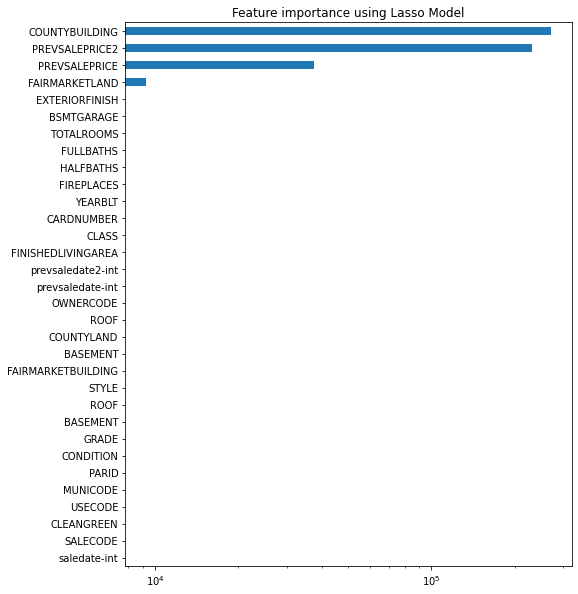

In [ ]:
imp_coef = coef.sort_values()

imp_coef.plot(kind = "barh",logx=True)
plt.title("Feature importance using Lasso Model")

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor(n_estimators=100, max_depth=20, random_state=0)
regr.fit(X_train, y_train)
print('Test score: ',regr.score(X_test, y_test))
print('Train score: ',regr.score(X_train, y_train))

Test score:  0.5227096537522461
Train score:  0.8971956117763806


Text(0.5, 1.0, 'Variable Importance')

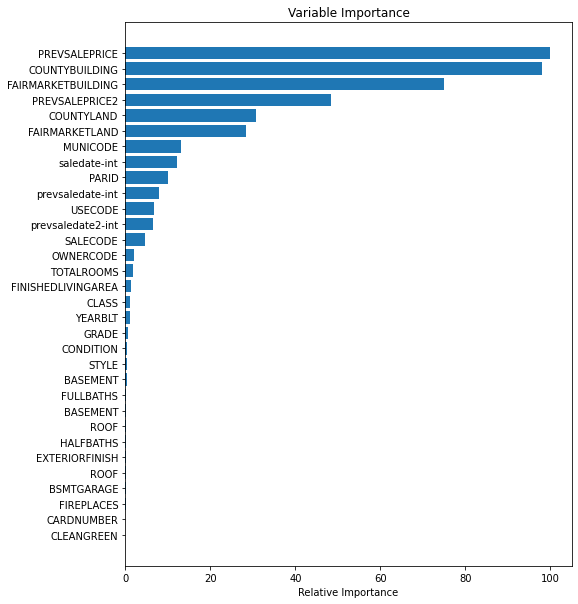

In [ ]:
feature_importance = regr.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())

sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5





plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')

# Bagging Regressor

In [ ]:
from sklearn.ensemble import BaggingRegressor

bg = BaggingRegressor(n_estimators=30, oob_score=True)
bg.fit(X_train, y_train)
print('Test score:',bg.score(X_test, y_test))
print('Train score:',bg.score(X_train, y_train))

Test score: 0.5881934318212749
Train score: 0.9272730505225507


Text(0.5, 1.0, 'Variable Importance')

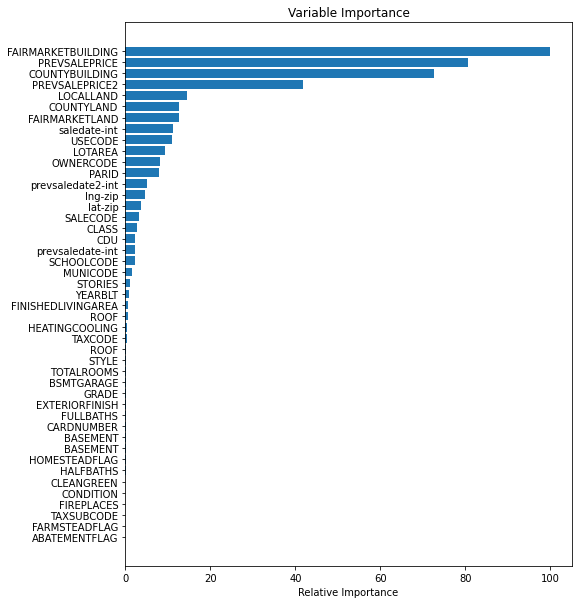

In [ ]:
#COMPUTING FEATURE IMPORATANCE THROUGH THE MEAN
feature_importance = np.mean([
    tree.feature_importances_ for tree in bg.estimators_
], axis=0)

#NORMALIZE FEATURE IMPORTANCE
feature_importance = 100.0 * (feature_importance / feature_importance.max())

#SORT FEATURE IMPORTANCE
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

#PLOT RESULTS
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')


# XGBoost

In [ ]:
import xgboost as xg 
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score 


# Instantiation 
xgb_r = xg.XGBRegressor(objective ='reg:squarederror', 
                  n_estimators = 110, seed = 10) 
  
# Fitting the model 
xgb_r.fit(X_train, y_train);

In [ ]:
# Predict the model 
test_pred = xgb_r.predict(X_test) 
train_pred = xgb_r.predict(X_train) 


# R2_score Computation 
test_score = np.sqrt(r2_score(y_test, test_pred)) 
train_score = np.sqrt(r2_score(y_train, train_pred)) 

print("Test Score : % f" %(test_score))
print("Train Score : % f" %(train_score))

Test Score :  0.737430
Train Score :  0.813892


Text(0.5, 0, 'Xgboost Feature Importance')

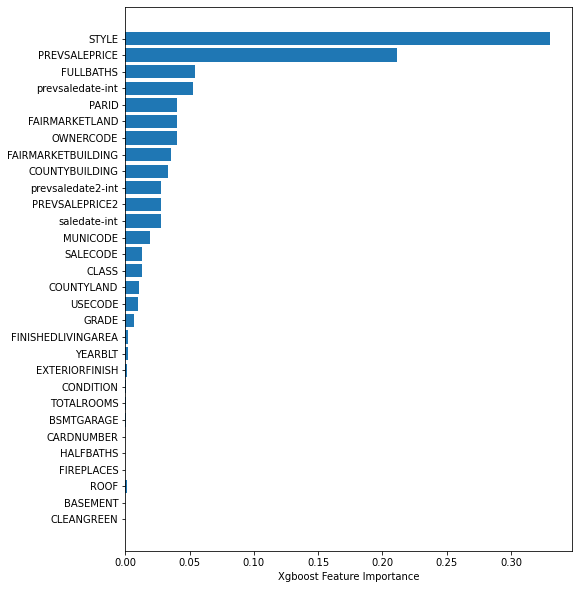

In [ ]:
sorted_idx = xgb_r.feature_importances_.argsort()
plt.barh(X.keys()[sorted_idx], xgb_r.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")

Text(0.5, 0, 'Permutation Importance')

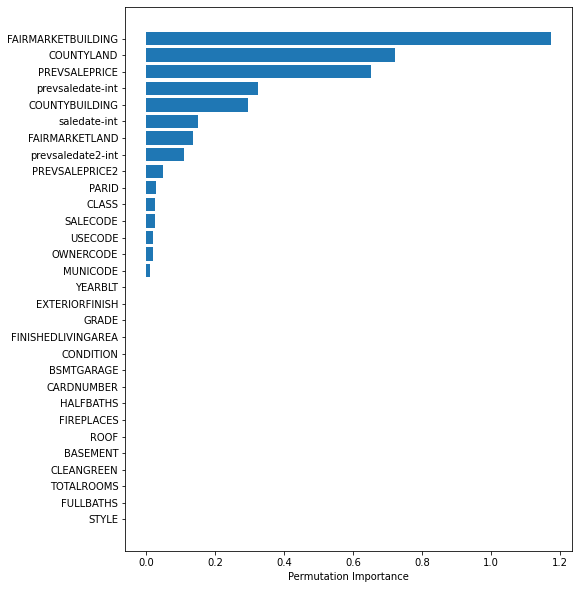

In [ ]:
from sklearn.inspection import permutation_importance

#LOOK AT THE PERMUTATION IMPORATANCE OF EACH VARIABLE
perm_importance = permutation_importance(xgb_r, X_test, y_test)

#SORTING AND PLOTTING THE PERMUTATION IMPORTANCE OF EACH FEATURE
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(X.keys()[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

# AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostRegressor

regr = AdaBoostRegressor(random_state=10, n_estimators=4)
regr.fit(X_train, y_train)
print('Test score:',regr.score(X_test, y_test))
print('Train score:', regr.score(X_train, y_train))


Test score: 0.3796879269076645
Train score: 0.8291866269503562


# SVM

In [ ]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline

SV=SVR(C=1,kernel='poly',epsilon=0.05, gamma='auto')
SV.fit(X_train,y_train)

print('Test score:',SV.score(X_test, y_test))
print('Train score:', SV.score(X_train, y_train))

Test score: 0.006653607247443016
Train score: 0.20124699144711555


In [ ]:
pickle.dump(SV, open('models/SV.pkl', 'wb'))

# SGD Regressor

In [ ]:
from sklearn.linear_model import SGDRegressor

SGD=SGDRegressor(max_iter=1000, tol=1e-3)
SGD.fit(X_train,y_train)
SGD.score(X_test,y_test)

-0.31348485150244554

# XGBoost Hyperparameter Tuning

In [ ]:
import xgboost as xg 
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score 
from sklearn.model_selection import GridSearchCV

# Instantiation 
xgb = xg.XGBRegressor(objective ='reg:squarederror', seed = 10) 

param_dic={'n_estimators':np.arange(110,170,20)}
grid=GridSearchCV(estimator=xgb, param_grid=param_dic,cv=4,verbose=123)

grid.fit(X_train,y_train)

pickle.dump(grid, open('models/Grid-XGB2.pkl', 'wb'))

Fitting 4 folds for each of 3 candidates, totalling 12 fits
[CV 1/4; 1/3] START n_estimators=110............................................
[CV 1/4; 1/3] END ..........................n_estimators=110; total time=  50.7s
[CV 2/4; 1/3] START n_estimators=110............................................
[CV 2/4; 1/3] END ..........................n_estimators=110; total time=  51.3s
[CV 3/4; 1/3] START n_estimators=110............................................
[CV 3/4; 1/3] END ..........................n_estimators=110; total time=  53.0s
[CV 4/4; 1/3] START n_estimators=110............................................
[CV 4/4; 1/3] END ..........................n_estimators=110; total time=  53.0s
[CV 1/4; 2/3] START n_estimators=130............................................
[CV 1/4; 2/3] END ..........................n_estimators=130; total time= 1.0min
[CV 2/4; 2/3] START n_estimators=130............................................
[CV 2/4; 2/3] END ..........................n_est

In [ ]:
print(grid.cv_results_)

{'mean_fit_time': array([51.82443881, 60.62179494, 69.56322086]), 'std_fit_time': array([1.02308105, 1.4672722 , 1.20149238]), 'mean_score_time': array([0.17602009, 0.22792816, 0.23294604]), 'std_score_time': array([0.00603333, 0.02854021, 0.02142464]), 'param_n_estimators': masked_array(data=[110, 130, 150],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'n_estimators': 110}, {'n_estimators': 130}, {'n_estimators': 150}], 'split0_test_score': array([0.53940075, 0.54168481, 0.54135978]), 'split1_test_score': array([0.03596345, 0.03652188, 0.03776456]), 'split2_test_score': array([0.56293295, 0.56136849, 0.56249489]), 'split3_test_score': array([0.45920805, 0.45345821, 0.44771299]), 'mean_test_score': array([0.3993763 , 0.39825835, 0.39733305]), 'std_test_score': array([0.21331102, 0.21276534, 0.21204349]), 'rank_test_score': array([1, 2, 3], dtype=int32)}


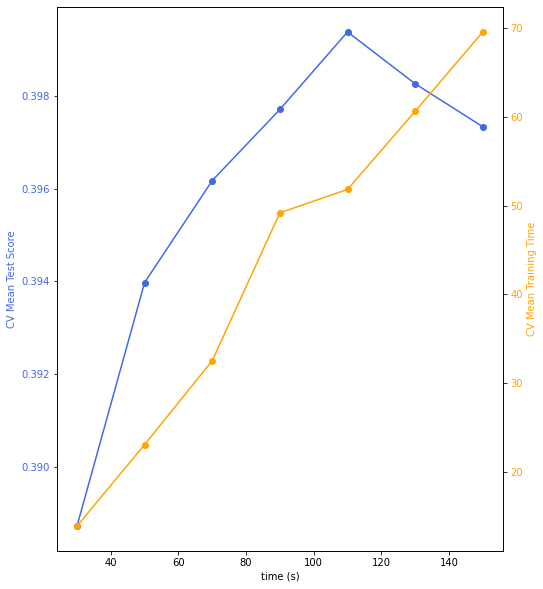

In [ ]:
dictt = pickle.load(open('models/Grid-XGB-data.pkl', 'rb'))

xx=dictt['xx']
yy=dictt['yy']
tt=dictt['tt']

fig, ax1 = plt.subplots()
ax1.plot(np.array(xx),np.array(yy),'o-',c='royalblue')
ax1.set_xlabel('time (s)')
ax1.set_ylabel('CV Mean Test Score', color='royalblue')
ax1.tick_params(axis='y', labelcolor='royalblue')

ax2 = ax1.twinx()
ax2.plot(np.array(xx),np.array(tt),'o-',c='orange')
ax2.set_ylabel('CV Mean Training Time', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

plt.savefig('figs/CV.png',format='png',dpi=300)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=4d883e40-705b-4ee7-9326-895000a955f5' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>